# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [103]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [104]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-104-8c32cb05a179>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [105]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [106]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


# Distribution of vouchers by LGA and Sport

In [107]:
# Identify how many rows in dataframe
sa_vouchers_scores.shape

(127526, 18)

In [108]:
# Statistical summary of dataframe
sa_vouchers_scores.describe()

,Participant_ID,Voucher_Value,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
count,1.275260e+05,127526.000000,127526.000000,118066.000000,118066.000000,118066.000000,118066.000000,118066.000000
mean,1.063764e+06,49.663951,2015.915100,981.049942,981.049942,971.090416,981.756314,68014.296046
std,3.681374e+04,2.700970,0.765087,44.454505,44.454505,56.889280,55.538098,50470.140017
min,1.000002e+06,5.000000,2015.000000,870.000000,870.000000,808.000000,798.000000,871.000000
25%,1.031883e+06,50.000000,2015.000000,955.000000,955.000000,927.000000,937.000000,22070.000000
50%,1.063764e+06,50.000000,2016.000000,974.000000,974.000000,973.000000,987.000000,62912.000000
75%,1.095646e+06,50.000000,2017.000000,1013.000000,1013.000000,997.000000,1018.000000,104922.000000
max,1.127526e+06,50.000000,2017.000000,1083.000000,1083.000000,1090.000000,1096.000000,159517.000000


In [109]:
# All participant LGA's in the dataframe
set(sa_vouchers_scores['Participant_LGA'])

{'ADELAIDE',
 'ADELAIDE HILLS',
 'ADELAIDE PLAINS',
 'ALEXANDRINA',
 'BAROSSA',
 'BARUNGA WEST',
 'BERRI BARMERA',
 'BURNSIDE',
 'CAMPBELLTOWN',
 'CEDUNA',
 'CHARLES STURT',
 'CLARE AND GILBERT VALLEYS',
 'CLEVE',
 'COOBER PEDY',
 'COPPER COAST',
 'ELLISTON',
 'FLINDERS RANGES',
 'FRANKLIN HARBOUR',
 'GAWLER',
 'GOYDER',
 'GRANT',
 'HOLDFAST BAY',
 'KANGAROO ISLAND',
 'KAROONDA EAST MURRAY',
 'KIMBA',
 'KINGSTON',
 'LIGHT',
 'LOWER EYRE PENINSULA',
 'LOXTON WAIKERIE',
 'MARION',
 'MID MURRAY',
 'MITCHAM',
 'MOUNT BARKER',
 'MOUNT GAMBIER',
 'MOUNT REMARKABLE',
 'MURRAY BRIDGE',
 'NARACOORTE LUCINDALE',
 'NO LGA',
 'NORTHERN AREAS',
 'NORWOOD PAYNEHAM AND ST PETERS',
 'ONKAPARINGA',
 'ORROROO/CARRIETON',
 'PETERBOROUGH',
 'PLAYFORD',
 'PORT ADELAIDE ENFIELD',
 'PORT AUGUSTA',
 'PORT LINCOLN',
 'PORT PIRIE',
 'PROSPECT',
 'RENMARK PARINGA',
 'ROBE',
 'ROXBY DOWNS',
 'SALISBURY',
 'SOUTHERN MALLEE',
 'STREAKY BAY',
 'TATIARA',
 'TEA TREE GULLY',
 'THE COORONG',
 'TUMBY BAY',
 'UNLEY',
 'V

In [110]:
# All sports in the dataframe
set(sa_vouchers_scores['Voucher_Sport'])

{'Archery',
 'Athletics',
 'Australian Rules',
 'BMX',
 'Badminton',
 'Baseball',
 'Basketball',
 'Bowls',
 'Calisthenics',
 'Cricket',
 'Cycling',
 'Dancesport',
 'Diving',
 'Equestrian',
 'Fencing',
 'Football (Soccer)',
 'Golf',
 'Gymnastics',
 'Hockey',
 'Ice Skating',
 'Ju Jitsu',
 'Judo',
 'Karate',
 'Kung Fu (Wu Shu)',
 'Lacrosse',
 'Motor Sport',
 'Motorcycling',
 'Netball',
 'Orienteering',
 'Paralympics',
 'Pony Clubs',
 'Roller Sports',
 'Rowing',
 'Rugby League',
 'Rugby Union',
 'Sailing',
 'Shooting',
 'Softball',
 'Squash',
 'Surf Lifesaving',
 'Surf Riding',
 'Swimming',
 'Table Tennis',
 'Taekwondo',
 'Tennis',
 'Touch',
 'Volleyball',
 'Water Polo',
 'Weightlifting',
 'Wrestling'}

### Distribution of vouchers by LGA 

In [111]:
# Display all elements
pd.set_option('display.max_rows', sa_vouchers_scores.shape[0]+1)

# Mean and Standard Deviation of vouchers for distribution analysis
print('Average vouchers for each Participant_LGA ->', round(sa_vouchers_scores['Participant_LGA'].value_counts().mean()))
print('Standard deviation on vouchers for Participant_LGA ->', round(sa_vouchers_scores['Participant_LGA'].value_counts().std()))

# Count the number of occurrences of LGA in dataframe, which indicates the number of vouchers in that LGA
sa_vouchers_scores['Participant_LGA'].value_counts()

Average vouchers for each Participant_LGA -> 1848
Standard deviation on vouchers for Participant_LGA -> 2348


ONKAPARINGA                       12782
SALISBURY                          8169
TEA TREE GULLY                     7219
PLAYFORD                           6940
CHARLES STURT                      6897
PORT ADELAIDE ENFIELD              6384
MARION                             5291
ADELAIDE HILLS                     4756
MITCHAM                            4662
MOUNT BARKER                       3469
MOUNT GAMBIER                      3271
ALEXANDRINA                        2979
BAROSSA                            2874
WEST TORRENS                       2844
CAMPBELLTOWN                       2567
WHYALLA                            2488
UNLEY                              2266
HOLDFAST BAY                       2215
BURNSIDE                           2213
PORT LINCOLN                       2125
LIGHT                              2066
PORT PIRIE                         1935
COPPER COAST                       1629
PORT AUGUSTA                       1522
GAWLER                             1505


We can directly get numerical data of the distribution of vouchers by <b><i>Participant_LGA</i></b> by doing value_counts(). By this, we can observe which particular LGA's stand out in terms of vouchers. We also get the mean and standard deviation of vouchers for this particular column. The mean value indicates the <b><i>evenly</i></b> distributed amount of vouchers across all LGA's, however the results show that values are far off the mean value. Furthermore, if we add the mean and standard deviation values, <b>4196</b>, anything 0 to this value would indicate a somewhat even distribution of vouchers for all LGA's. Therefore, <b><i>ONKAPARINGA to MITCHAM</i></b> from the list above have majority of vouchers for there to be a even distribution.

### Distribution of vouchers by Sport

In [112]:
# Display all elements
pd.set_option('display.max_rows', sa_vouchers_scores.shape[0]+1)

# Mean and Standard Deviation of vouchers for distribution analysis
print('Average vouchers for each Voucher_Sport ->', round(sa_vouchers_scores['Voucher_Sport'].value_counts().mean()))
print('Standard deviation on vouchers for Voucher_Sport ->', round(sa_vouchers_scores['Voucher_Sport'].value_counts().std()))

# Count the number of occurrences of sport in dataframe, which indicates the number of vouchers for that sport.
sa_vouchers_scores['Voucher_Sport'].value_counts()

Average vouchers for each Voucher_Sport -> 2551
Standard deviation on vouchers for Voucher_Sport -> 7724


Australian Rules     47224
Netball              24017
Football (Soccer)    15775
Gymnastics            9823
Basketball            6016
Athletics             4518
Tennis                3742
Hockey                3026
Calisthenics          2522
Cricket               1875
Surf Lifesaving       1442
Swimming              1204
Taekwondo              910
Baseball               865
Rugby Union            734
Lacrosse               656
Softball               548
Rugby League           270
Equestrian             265
Squash                 249
Judo                   210
Golf                   188
Table Tennis           166
BMX                    157
Roller Sports          148
Cycling                105
Motorcycling            97
Karate                  91
Diving                  89
Ice Skating             86
Fencing                 84
Volleyball              62
Orienteering            56
Water Polo              48
Motor Sport             45
Sailing                 40
Archery                 34
T

We can directly get numerical data of the distribution of vouchers by <b><i>Voucher_Sport</i></b> by doing value_counts(). By this, we can observe which particular sport stand out in terms of vouchers. We also get the mean and standard deviation of vouchers for this particular column. The mean value indicates the <b><i>evenly</i></b> distributed amount of vouchers across all sport, however the results show that values are far off the mean value. Furthermore, if we add the mean and standard deviation values, <b>10275</b>, anything 0 to this value would indicate a somewhat even distribution of vouchers for all sports. Therefore, <b><i>Australian Rules, Netball and Football (Soccer)</i></b> have majority of vouchers for there to be a even distribution.

# Analysis

The distribution of vouchers across the LGAs and sports can be viewed by the value_counts() function. The LGA with the most amount of vouchers is <i>'ONKAPARINGA'</i>, followed by <i>'SALISBURY'</i> and <i>'TEA TREE GULLY'</i>. The sport with the most amount of vouchers is <i>'Australian Rules'</i>, followed by <i>'Netball'</i> and <i>'Football'</i>. LGA <b><i>'ONKAPARINGA'</i></b> stands out with the most vouchers at <b>12782</b> and sport <b><i>'Australian Rules'</i></b> stands out with the most vouchers at <b>47224.</b> For this analysis, I have not included a graph presentation as it was not necessary. The range of values for value_counts() in the dataframe for both <b><i>Participant_LGA</i></b> and <b><i>Voucher_Sport</i></b> was too large at about over 40000 and 10000 in difference from min and max values. This would be difficult to plot as the big range of values may not be easily distinguishable in visual represenation unless it is shown on a large screen.

# Are some sports more popular in other parts of the state?

In [113]:
# Groupby for 2 columns Voucher_Sport and Participant_LGA and get the statistical summmary
sa_vouchers_scores.groupby(['Voucher_Sport'])['Participant_LGA'].describe()

,count,unique,top,freq
Voucher_Sport,,,,
Archery,34,11,ALEXANDRINA,9
Athletics,4518,57,ONKAPARINGA,541
Australian Rules,47224,69,ONKAPARINGA,5258
BMX,157,17,ONKAPARINGA,51
Badminton,4,2,ALEXANDRINA,3
Baseball,865,33,ONKAPARINGA,133
Basketball,6016,54,WHYALLA,605
Bowls,2,2,MARION,1
Calisthenics,2522,42,ONKAPARINGA,353


We do a Groupby selection of two columns <b>Voucher_Sport</b> and <b>Participant_LGA</b>, then using the describe function to print the statistical summary on the number of vouchers of sport for all LGA's. This table shows us the total number of vouchers for a particular sport distrubuted amongst the total number of unique LGA's. It also indicates the sport is most popular (most vouchers) in that particular LGA in the <b>top</b> column. The <b>freq</b> column indicates the number of vouchers the LGA from the <b>top</b> column has. For example, <b>Athletics is most popular in ONKAPARINGA with 541/4518 vouchers</b> which calculates to <b>12% of vouchers of Athletics in ONKAPARINGA</b>.

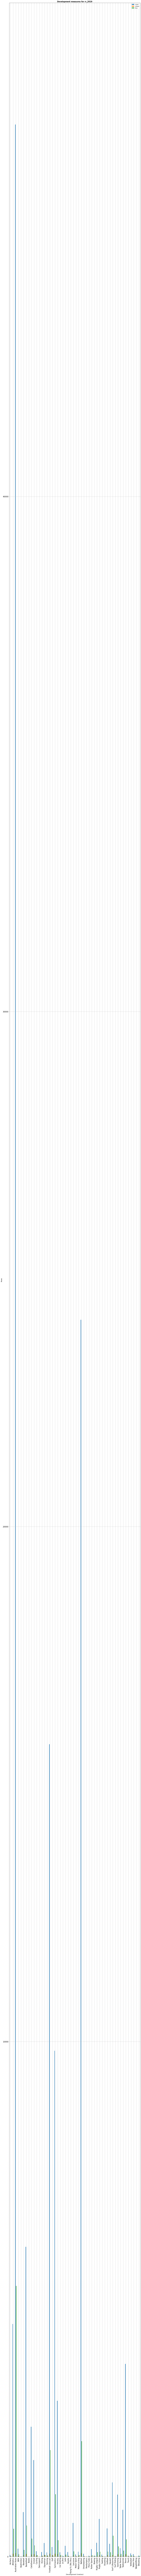

In [114]:
sa_vouchers_scores.groupby(['Voucher_Sport'])['Participant_LGA'].describe().plot(kind='bar',
        grid=True,
        figsize=(20,400),
        fontsize=15)
plt.xticks(rotation=90)
plt.title('Development measures for rr_2019', fontsize=15, fontweight='bold')
plt.xlabel('Development (metres)', fontsize=13)
plt.ylabel("Rows", fontsize=13);

In [115]:
# Groupby for 2 columns Voucher_Sport and Participant_LGA and get the number of vouchers for each LGA for a particular sport
sa_vouchers_scores.groupby(['Voucher_Sport'])['Participant_LGA'].value_counts()

Voucher_Sport      Participant_LGA               
Archery            ALEXANDRINA                          9
                   VICTOR HARBOR                        8
                   ADELAIDE HILLS                       3
                   ONKAPARINGA                          3
                   YANKALILLA                           3
                   BURNSIDE                             2
                   MOUNT BARKER                         2
                   CHARLES STURT                        1
                   HOLDFAST BAY                         1
                   SALISBURY                            1
                   WEST TORRENS                         1
Athletics          ONKAPARINGA                        541
                   CHARLES STURT                      447
                   PORT ADELAIDE ENFIELD              298
                   TEA TREE GULLY                     280
                   MARION                             238
                   SAL

# Analysis

We can take a more in-depth look at the distribution of vouchers for each sport across the LGA's. With this data, we can state the level of significance for popularity of a sport in a particular LGA. For example, <b>Australian Rules</b> has <b>5258</b> vouchers in the top LGA which is nearly double the next LGA for number of vouchers and <b>Basketball</b> has <b>605</b> vouchers in the top LGA which is also nearly double the next LGA for number of vouchers. The graph above shows the visual representation, however it is not so feasbile as the big range of value make it difficult to read smaller values. The graph above shows an example even at 400 height. Nevertheless,  with these results, we can state that other sports are more popular in other parts of the state.

# Are any LGAs over/under represented in their use of vouchers?

In [116]:
# Calcualte total number of vouchers in state
Num_Voucher_State = sa_vouchers_scores['Participant_LGA'].value_counts().sum()
print('Total number of vouchers in state ->', Num_Voucher_State)

Total number of vouchers in state -> 127526


In [117]:
# Calculate total number of LGAs in state
Num_LGA = sa_vouchers_scores['Participant_LGA'].nunique()
print('Total number of LGAs in state ->', Num_LGA)

Total number of LGAs in state -> 69


In [118]:
# Calculate equal distribution of vouchers amongst each LGAs
Equal_Vouchers_LGA = Num_Voucher_State/Num_LGA
print('Equal distribution of vouchers amongst each LGA ->', Num_Voucher_State/Num_LGA)

Equal distribution of vouchers amongst each LGA -> 1848.2028985507247


In [119]:
# How many vouchers each LGA has used 
LGA_Vouchers = sa_vouchers_scores['Participant_LGA'].value_counts()

# Convert to dict
LGA_Vouchers1 = LGA_Vouchers.to_dict()

# Map into dataframe
sa_vouchers_scores['Voucher_Use'] = sa_vouchers_scores['Participant_LGA'].map(LGA_Vouchers1)
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Voucher_Use
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0,12782
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0,12782
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0,12782
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0,12782
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0,12782


In [120]:
# sa_vouchers_scores['Voucher_Use'] = sa_vouchers_scores.groupby(['Participant_LGA']).transform('count')
# sa_vouchers_scores.head()

In [121]:
sa_vouchers_scores.shape

(127526, 19)

In [122]:
# Calculate percentage of vouchers used in each LGA to amount of vouchers for equal distribution
Percentage_of_vouchers = (LGA_Vouchers/Equal_Vouchers_LGA*100).round().astype(str) + '%'

# Show results in a dataframe table format
Percentage_of_vouchers.to_frame('Percentage')

,Percentage
ONKAPARINGA,692.0%
SALISBURY,442.0%
TEA TREE GULLY,391.0%
PLAYFORD,375.0%
CHARLES STURT,373.0%
PORT ADELAIDE ENFIELD,345.0%
MARION,286.0%
ADELAIDE HILLS,257.0%
MITCHAM,252.0%
MOUNT BARKER,188.0%


In [123]:
# print(sa_vouchers_scores.groupby(['Participant_LGA'])['Population'].value_counts())
df = sa_vouchers_scores.groupby(['Participant_LGA'])['Population'].value_counts()
df.to_frame('Voucher_Use')

,,Voucher_Use
Participant_LGA,Population,
ADELAIDE,19606.0,302
ADELAIDE HILLS,38601.0,4756
ALEXANDRINA,23693.0,2979
BAROSSA,22174.0,2874
BARUNGA WEST,2467.0,333
BURNSIDE,42168.0,2213
CAMPBELLTOWN,97060.0,2567
CEDUNA,3485.0,350
CHARLES STURT,104922.0,6897


# Analysis

In order to state which LGA's are under or over represented in terms of used vouchers, we need to calculate the equal distribution of vouchers for every LGA from the total vouchers used in the state. To to that, we divide the number of LGA from the total number of vouchers used to get the equal distribution amount for each LGA. With this result, we can calculate the percentage in which how much an LGA is over or under represented by comparing it to the amount of vouchers used in an LGA. Here, 100% is the equal distribution amount and as seen from above, LGA <b>ONKAPARINGA</b> is <b>692%</b> of the equal distribution amount, which is hugely over representing that state in terms of vouchers used. Similarly, anything under 100% state the LGA is under represented.

# Relationship with SEIFA measures and voucher use in an LGA

In [124]:
sa_vouchers_scores.head(5)

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Voucher_Use
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0,12782
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0,12782
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0,12782
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0,12782
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0,12782


In [125]:
# Check NaN values for SEIFA measures
sa_vouchers_scores.isna().sum()

Participant_ID                   0
Participant_Suburb               0
Club_Previous_Member             0
Participant_ATSI_Indicator       0
Participant_CALD_Indicator       0
Participant_Sex                  0
Voucher_Value                    0
Club_Name                        0
Voucher_Sport                    0
Participant_LGA                  0
Participant_Electorate           0
Voucher_Completion_Date       2080
Voucher_Claim_Year               0
IEO                           9460
IER                           9460
IRSAD                         9460
IRSD                          9460
Population                    9460
Voucher_Use                      0
dtype: int64

In [126]:
# Drop NaN values
sa_vouchers_scores = sa_vouchers_scores.dropna()

In [127]:
# Check it has been dropped
sa_vouchers_scores.isna().sum()

Participant_ID                0
Participant_Suburb            0
Club_Previous_Member          0
Participant_ATSI_Indicator    0
Participant_CALD_Indicator    0
Participant_Sex               0
Voucher_Value                 0
Club_Name                     0
Voucher_Sport                 0
Participant_LGA               0
Participant_Electorate        0
Voucher_Completion_Date       0
Voucher_Claim_Year            0
IEO                           0
IER                           0
IRSAD                         0
IRSD                          0
Population                    0
Voucher_Use                   0
dtype: int64

In [128]:
sa_vouchers_scores.describe()

,Participant_ID,Voucher_Value,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population,Voucher_Use
count,1.162290e+05,116229.000000,116229.000000,116229.000000,116229.000000,116229.000000,116229.000000,116229.000000,116229.000000
mean,1.064063e+06,49.647928,2015.894846,981.056849,981.056849,971.121166,981.801375,68156.654518,5058.238933
std,3.701109e+04,2.769947,0.758365,44.405211,44.405211,56.818625,55.464707,50501.430768,3610.105006
min,1.000002e+06,5.000000,2015.000000,870.000000,870.000000,808.000000,798.000000,871.000000,39.000000
25%,1.032145e+06,50.000000,2015.000000,955.000000,955.000000,927.000000,937.000000,22070.000000,2213.000000
50%,1.064170e+06,50.000000,2016.000000,974.000000,974.000000,973.000000,987.000000,62912.000000,4662.000000
75%,1.096617e+06,50.000000,2016.000000,1013.000000,1013.000000,997.000000,1018.000000,104922.000000,6940.000000
max,1.127526e+06,50.000000,2017.000000,1083.000000,1083.000000,1090.000000,1096.000000,159517.000000,12782.000000


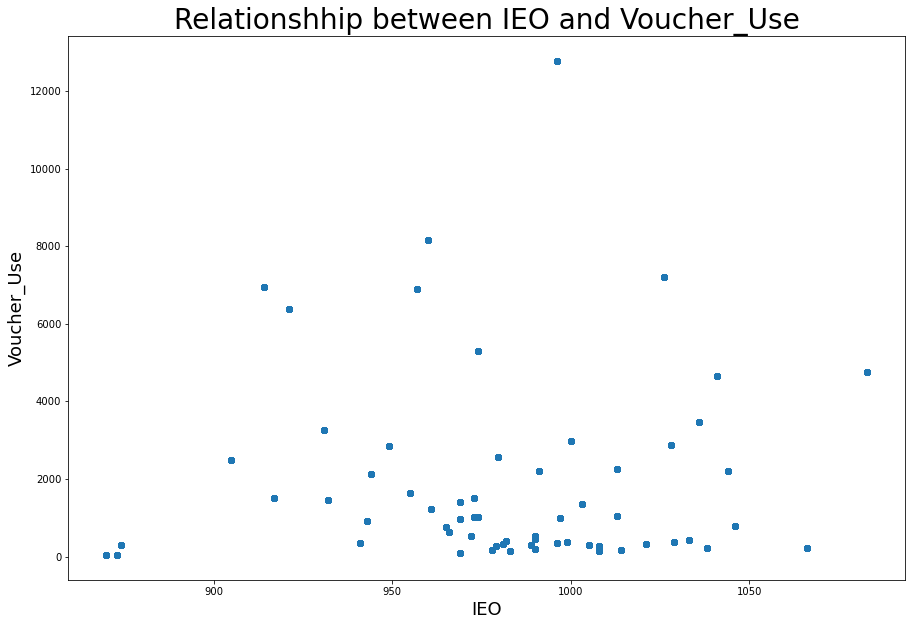

In [141]:
# Scatterplot for IEO and Voucher_Use to visually see relationship
plt.figure(figsize = (15, 10))
plt.title('Relationshhip between IEO and Voucher_Use', fontsize=28)
plt.xlabel('IEO', fontsize=18)
plt.ylabel('Voucher_Use', fontsize=18)
plt.scatter(x='IEO', y='Voucher_Use', data=sa_vouchers_scores )

From the scatterplot above, it is difficult to state that there is visually an identifiable relationship between IEO and Voucher_Use. Most points are grouped by low Voucher_Use and 1000 IEO score.

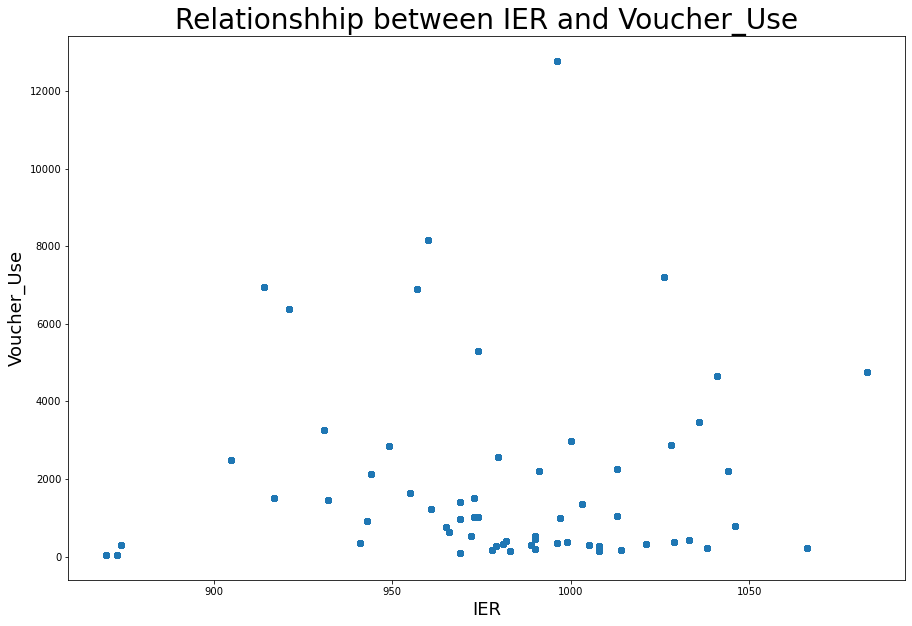

In [142]:
# Scatterplot for IER and Voucher_Use to visually see relationship
plt.figure(figsize = (15, 10))
plt.title('Relationshhip between IER and Voucher_Use', fontsize=28)
plt.xlabel('IER', fontsize=18)
plt.ylabel('Voucher_Use', fontsize=18)
plt.scatter(x='IER', y='Voucher_Use', data=sa_vouchers_scores )

The above scatterplot shows a very similar graph if not identical, to IEO, indicating the relationship between IEO and IER scores. Most points are grouped by low Voucher_Use and 1000 IER score.

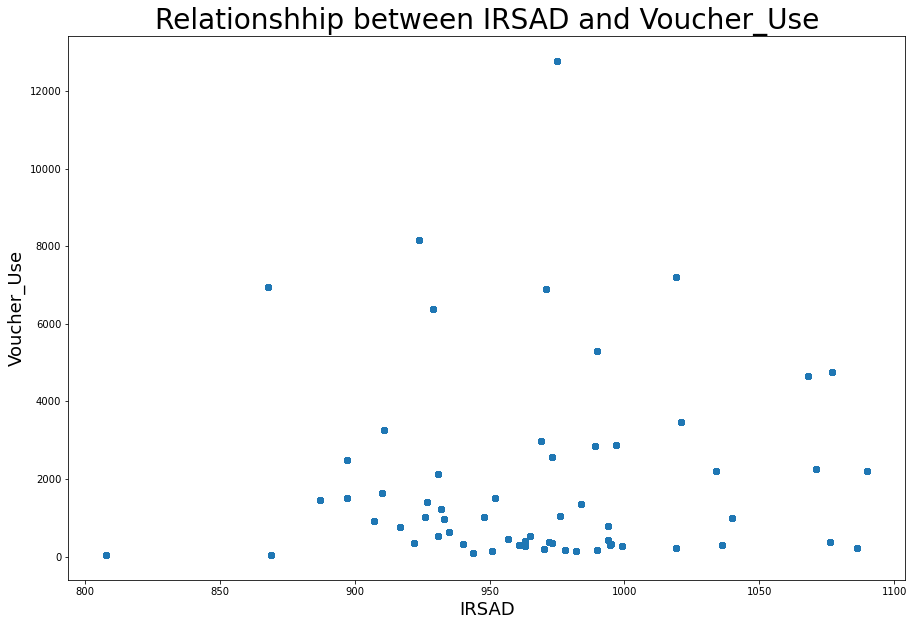

In [143]:
# Scatterplot for IRSAD and Voucher_Use to visually see relationship
plt.figure(figsize = (15, 10))
plt.title('Relationshhip between IRSAD and Voucher_Use', fontsize=28)
plt.xlabel('IRSAD', fontsize=18)
plt.ylabel('Voucher_Use', fontsize=18)
plt.scatter(x='IRSAD', y='Voucher_Use', data=sa_vouchers_scores )

The above scatterplot shows a dense point around 950 and 1000 IRSAD scores with low voucher uses at around 1000 and lower. There are higher number of voucher uses as IRSAD scores increases, however it is not easily distinguishable from general perspective. 

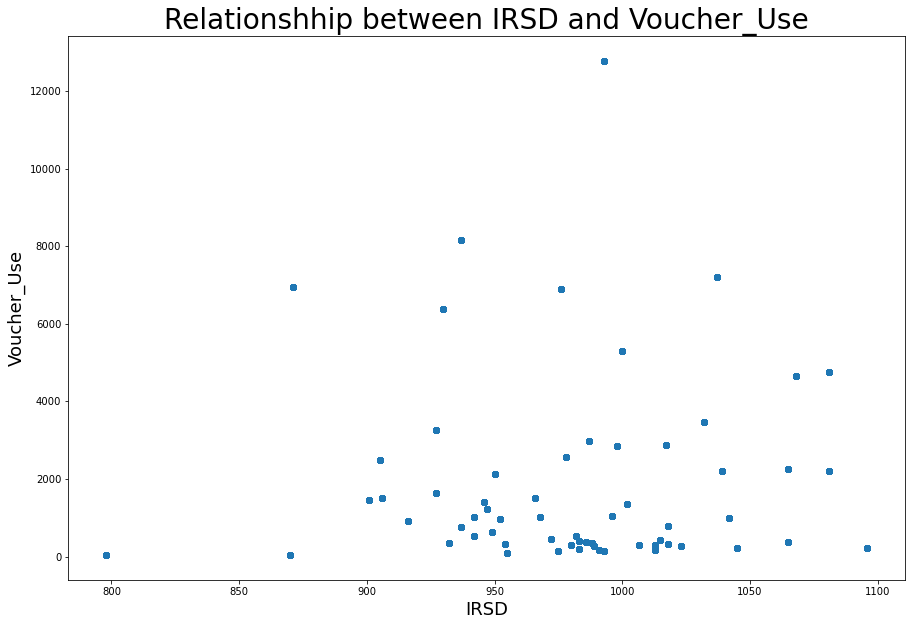

In [144]:
# Scatterplot for IRSD and Voucher_Use to visually see relationship
plt.figure(figsize = (15, 10))
plt.title('Relationshhip between IRSD and Voucher_Use', fontsize=28)
plt.xlabel('IRSD', fontsize=18)
plt.ylabel('Voucher_Use', fontsize=18)
plt.scatter(x='IRSD', y='Voucher_Use', data=sa_vouchers_scores )

The above scatterplot shows similarity to IRSAD as majority of its points seem to be visually identical. Again, there is a dense point from 950 to 1050 IRSD scores with low voucher use at 1000 or lower. However, it is still difficult to state a trend in relationship between the SEIFA measure and voucher use.

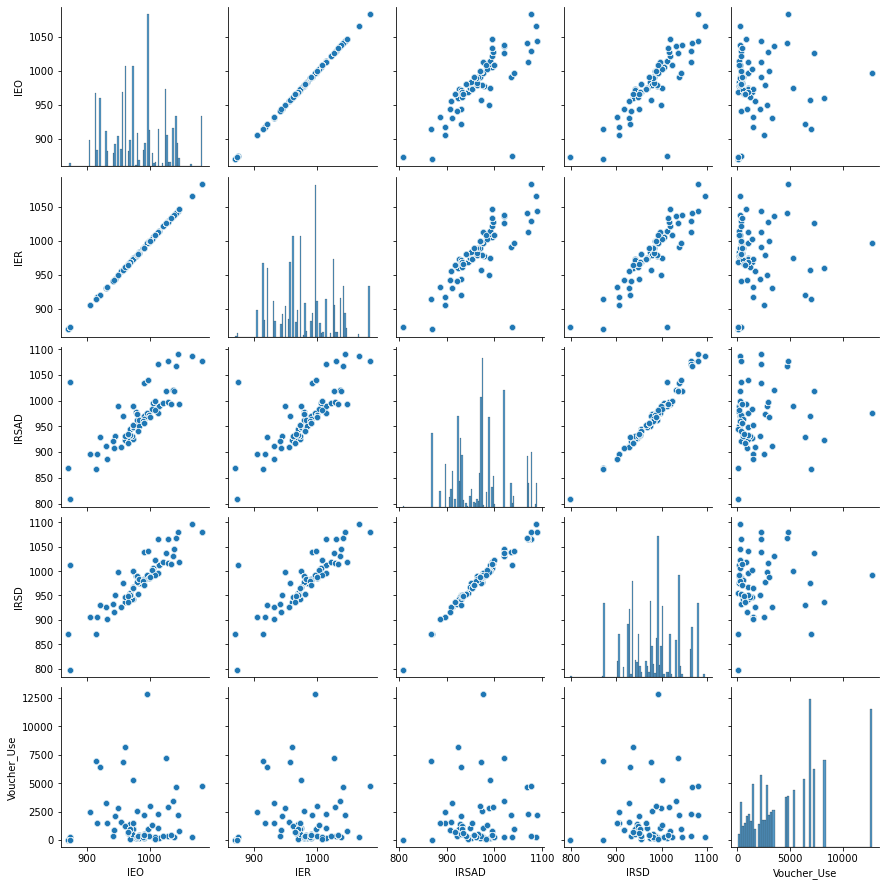

In [147]:
# Pairplot
sns.pairplot(sa_vouchers_scores[['IEO', 'IER', 'IRSAD', 'IRSD', 'Voucher_Use']])

We can visualize more efficiently as graphs are easily comparable next to each other. As stated above, IEO and IER share a similar relationship, and IRSAD and IRSD share a similar relationship. This is evident as seen in the pairplot graph above wehn comparing the SEIFA measures with each other, the points are consistently in a diagonal line.

In [149]:
# Correlation coefficients
print('IEO/Voucher_Use: Correlation coefficient ->', sa_vouchers_scores['IEO'].corr(sa_vouchers_scores['Voucher_Use']))
print('IER/Voucher_Use: Correlation coefficient ->', sa_vouchers_scores['IER'].corr(sa_vouchers_scores['Voucher_Use']))
print('IRSAD/Voucher_Use: Correlation coefficient ->', sa_vouchers_scores['IRSAD'].corr(sa_vouchers_scores['Voucher_Use']))
print('IRSD/Voucher_Use: Correlation coefficient ->', sa_vouchers_scores['IRSD'].corr(sa_vouchers_scores['Voucher_Use']))

IEO/Voucher_Use: Correlation coefficient -> -0.000727248784298072
IER/Voucher_Use: Correlation coefficient -> -0.000727248784298072
IRSAD/Voucher_Use: Correlation coefficient -> -0.05526267411322107
IRSD/Voucher_Use: Correlation coefficient -> -0.04049487012546997


# Analysis

Furthermore, we look at the correlation coefficients between the SEIFA measures and Voucher_Use columns. A positive correlation coefficient signifies both columns move in the same direction, indicating a relationship between them. A negative correaltion coefficient signifies both columns move in the opposite direction, indicating no relationship between them. All SEIFA measures compared with Voucher_Use in an LGA results in a negative correlation coefficient, indicating SEIFA measures do not share a relationship with Voucher_Use in an LGA.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [30]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [31]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-31-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
